In [197]:
# to allow relative imports
import os
from sys_path_util import append_sys_path
append_sys_path()

from lib.experiments.utils.data_repo_api import DataRepoAPI

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from urllib.request import urlopen
import pickle

from lib.configuration import DATA_REPO_URL_RAW

In [198]:
POPULATION = 854757

covid = DataRepoAPI.get_csv('covid_by_county.csv')
covid.head()

,Date updated,County code,County,Total cases,Confirmed cases,Probable cases,Total case rate,Hospitalized cases,Total deaths,Confirmed deaths,Probable deaths
0,06/02/2020,1,Fairfield,"15,789","15,087",702,"1,673",134,"1,289",998,291.0
1,06/02/2020,2,Hartford,"10,593","9,914",679,"1,187",92,"1,259",958,301.0
2,06/02/2020,3,Litchfield,"1,404","1,338",66,775,5,133,113,20.0
3,06/02/2020,4,Middlesex,"1,161","1,104",57,714,16,152,118,34.0
4,06/02/2020,5,New Haven,"11,548","11,161",387,"1,347",150,990,843,147.0


In [199]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2960 entries, 0 to 2959
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date updated        2960 non-null   object 
 1   County code         2960 non-null   int64  
 2   County              2960 non-null   object 
 3   Total cases         2960 non-null   object 
 4   Confirmed cases     2416 non-null   object 
 5   Probable cases      2416 non-null   object 
 6   Total case rate     2696 non-null   object 
 7   Hospitalized cases  2960 non-null   int64  
 8   Total deaths        2960 non-null   object 
 9   Confirmed deaths    2416 non-null   object 
 10  Probable deaths     2416 non-null   float64
dtypes: float64(1), int64(2), object(8)
memory usage: 254.5+ KB


In [200]:
# transform dates
covid['Date updated'] = pd.to_datetime(covid['Date updated'], format="%m/%d/%Y")
covid = covid.sort_values('Date updated').reset_index(drop=True)

col_transform = {
    'Total cases': 'float32',
    'Confirmed cases': 'float32',
    'Probable cases': 'float32',
    'Total case rate': 'float32',
    'Hospitalized cases': 'float32',
    'Total deaths': 'float32',
    'Confirmed deaths': 'float32',
    'Probable deaths': 'float32',
}

for c in col_transform:
    covid[c] = covid[c].apply(lambda x: x.replace(',', '') if type(x) == str else x, 1)

covid.replace('NaN', np.NaN, inplace=True)
    
# transform numbers
covid = covid.astype(col_transform)

# filter new haven county (code = 5)
new_haven_covid = covid[covid["County code"] == 5].copy()
new_haven_covid.reset_index(drop=True, inplace=True)
new_haven_covid.head()

start_date = new_haven_covid.loc[0, 'Date updated'].date()

In [201]:
def days_since_start(date):
    return (date - start_date).days

In [202]:
new_haven_covid['Date updated'] = new_haven_covid['Date updated'].apply(lambda x: days_since_start(x.date()))

In [203]:
new_haven_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date updated        370 non-null    int64  
 1   County code         370 non-null    int64  
 2   County              370 non-null    object 
 3   Total cases         370 non-null    float32
 4   Confirmed cases     302 non-null    float32
 5   Probable cases      302 non-null    float32
 6   Total case rate     337 non-null    float32
 7   Hospitalized cases  370 non-null    float32
 8   Total deaths        370 non-null    float32
 9   Confirmed deaths    302 non-null    float32
 10  Probable deaths     302 non-null    float32
dtypes: float32(8), int64(2), object(1)
memory usage: 20.4+ KB


In [272]:
first_val = new_haven_covid.loc[0, 'Total cases']
initial_infection_rate = first_val / POPULATION
new_cases = new_haven_covid['Total cases'].diff().fillna(first_val).values.tolist()

new_haven_covid['New cases'] = new_cases

agg = {'New cases': ['sum'], 'Date updated': ['first']}
first200 = new_haven_covid.loc[new_haven_covid.index <= 190, :].copy()
first200 = first200.groupby(np.arange(len(first200.index))//10, axis=0).agg(agg)
first200.columns = list(agg.keys())

In [275]:
initial_infection_rate

0.00010412316014960977

<AxesSubplot:xlabel='Date updated'>

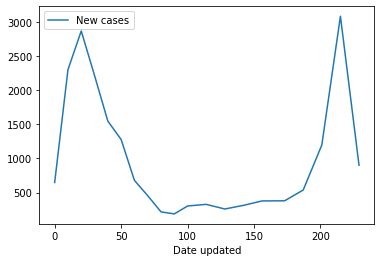

In [259]:
first200.plot(x='Date updated', y='New cases')

## Modelled

In [211]:
url = DATA_REPO_URL_RAW + '/app-data/seir_mobility_pre.pkl'

with urlopen(url) as f:
    df = pickle.load(f)
    
def df_group_mean(df):
    grouped = df.groupby(['time', 'compartment']).mean()
    grouped.reset_index(inplace=True)
    return grouped

grouped = df_group_mean(df)

In [212]:
grouped.head()

,time,compartment,value
0,0.0,E,0.01016
1,0.0,I,0.00000
2,0.0,R,0.00000
3,0.0,S,1.01158
4,10.0,E,0.01593


In [231]:
wide = grouped.pivot(index=['time'], columns=['compartment'], values='value')
wide = wide * POPULATION
wide.reset_index(inplace=True)

first_val = (-1) * (wide.loc[0, 'E'] + wide.loc[0, 'I'])
new_cases = (wide['S'].diff().fillna(first_val) * (-1)).values.tolist()
wide['New cases'] = new_cases

In [232]:
wide.head()

compartment,time,E,I,R,S,New cases
0,0.0,8684.33112,0.00000,0.00000,864655.08606,8684.33112
1,10.0,13616.27901,12274.31052,6077.32227,841371.50538,23283.58068
2,20.0,35062.13214,37002.43053,28711.28763,772563.56688,68807.93850
3,30.0,48473.26947,67525.80300,83022.54741,674317.79730,98245.76958
4,40.0,42242.09094,83031.09498,159642.96489,588423.26637,85894.53093


<AxesSubplot:xlabel='time'>

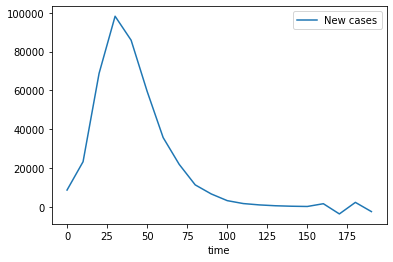

In [234]:
wide.plot(x='time', y='New cases')

## Comparison

In [269]:
x1 = wide['time'].values.tolist()
x2 = first200['Date updated'].values.tolist()

y1 = wide['New cases'].pct_change().fillna(0).values.tolist()
y2 = first200['New cases'].pct_change().fillna(0).values.tolist()

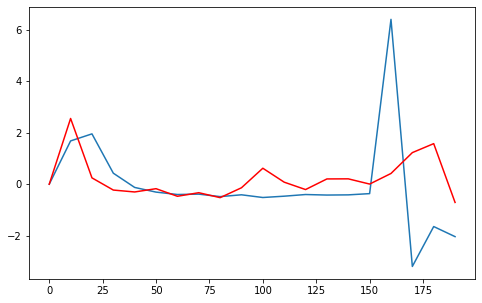

In [271]:
plt.figure(num = 3, figsize=(8, 5))
plt.plot(x1, y1)
plt.plot(x1, y2, color='red')
plt.show()